In [1]:
%load_ext autoreload
%autoreload 2

import asyncio, copy, os, socket, sys, time
from functools import partial
from multiprocessing import Pool, Process
from pathlib import Path
from tqdm import tqdm

import torch
from torch import optim

import shap
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "../../")))
from libs import agg, data, fl, log, plot, poison, resnet, sim, wandb
from cfgs.fedargs import *

In [2]:
project = 'fl-shap'
name = 'fedavg-cnn-mnist'

#Define Custom CFGs
fedargs.num_clients = 10
fedargs.dataset = "MEDNIST"
fedargs.model = nn.MedNet()
mal_clients = [c for c in range(5)]
shap_explain["is"] = True

# Save Logs To File (info | debug | warning | error | critical) [optional]
log.init("info")
wb = wandb.init(name, project)

wandb: Currently logged in as: kasyah (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.18 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [3]:
# Device settings
use_cuda = fedargs.cuda and torch.cuda.is_available()
torch.manual_seed(fedargs.seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

In [4]:
# Prepare clients
host = socket.gethostname()
clients = [host + "(" + str(client + 1) + ")" for client in range(fedargs.num_clients)]

In [5]:
# Initialize Global and Client models
global_model = copy.deepcopy(fedargs.model)
# Load Data to clients
train_data, test_data = data.load_dataset(fedargs.dataset, only_to_tensor = True)

In [6]:
clients_data = data.split_data(train_data, clients)

<h1>SHAP: Trim Data For Class Sniffing</h1>

In [7]:
if shap_explain["is"]:
    for client in mal_clients:
        clients_data[clients[client]] = shap_explain["trim_data"](clients_data[clients[client]], shap_explain["trim_labels"], shap_explain["trim_percent"])    

In [8]:
client_train_loaders, _ = data.load_client_data(clients_data, fedargs.client_batch_size, None, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=fedargs.test_batch_size, shuffle=True, **kwargs)

client_details = {
        client: {"train_loader": client_train_loaders[client],
                 "model": copy.deepcopy(global_model),
                 "model_update": None}
        for client in clients
    }

In [9]:
def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)

    return wrapped

@background
def process(client, epoch, model, train_loader, fedargs, device):
    # Train
    model_update, model, loss = fedargs.train_func(model, train_loader, 
                                                   fedargs.learning_rate,
                                                   fedargs.weight_decay,
                                                   fedargs.local_rounds, device)

    log.jsondebug(loss, "Epoch {} of {} : Federated Training loss, Client {}".format(epoch, fedargs.epochs, client))
    log.modeldebug(model_update, "Epoch {} of {} : Client {} Update".format(epoch, fedargs.epochs, client))
    
    return model_update, model

In [10]:
import time
start_time = time.time()

fedargs.epochs = 5
    
# Federated Training
for epoch in tqdm(range(fedargs.epochs)):
    log.info("Federated Training Epoch {} of {}".format(epoch, fedargs.epochs))
    
    # Global Model Update
    if epoch > 0:     
        # Average
        global_model = fl.federated_avg(client_model_updates, global_model)
        log.modeldebug(global_model, "Epoch {} of {} : Server Update".format(epoch, fedargs.epochs))
        
        # Test and Log
        global_test_output = fedargs.eval_func(global_model, test_loader, device)
        wb.log({"epoch": epoch, "time": time.time(), "acc": global_test_output["accuracy"], "loss": global_test_output["test_loss"]})
        log.jsoninfo(global_test_output, "Global Test Outut after Epoch {} of {}".format(epoch, fedargs.epochs))
        
        # Update client models
        #for client in clients:
        #    client_details[client]['model'] = copy.deepcopy(global_model)

    # Clients
    tasks = [process(client, epoch, client_details[client]['model'],
                     client_details[client]['train_loader'],
                     fedargs, device) for client in clients]
    try:
        updates = fedargs.loop.run_until_complete(asyncio.gather(*tasks))
    except KeyboardInterrupt as e:
        log.error("Caught keyboard interrupt. Canceling tasks...")
        tasks.cancel()
        fedargs.loop.run_forever()
        tasks.exception()

    for client, (model_update, model) in zip(clients, updates):
        client_details[client]['model_update'], client_details[client]['model'] = model_update, model
    client_model_updates = {client: details["model_update"] for client, details in client_details.items()}

print(time.time() - start_time)

 20%|██        | 1/5 [01:53<07:32, 113.17s/it]2022-06-20 17:54:33,720 - <ipython-input-10-e30b3487bc76>::<module>(l:8) : Federated Training Epoch 1 of 5 [MainProcess : MainThread (INFO)]
2022-06-20 17:54:38,392 - <ipython-input-10-e30b3487bc76>::<module>(l:19) : Global Test Outut after Epoch 1 of 5 {
    "accuracy": 80.89906700593723,
    "correct": 4769,
    "test_loss": -8.67054540231331
} [MainProcess : MainThread (INFO)]
 40%|████      | 2/5 [04:00<06:04, 121.47s/it]2022-06-20 17:56:41,005 - <ipython-input-10-e30b3487bc76>::<module>(l:8) : Federated Training Epoch 2 of 5 [MainProcess : MainThread (INFO)]
2022-06-20 17:56:46,202 - <ipython-input-10-e30b3487bc76>::<module>(l:19) : Global Test Outut after Epoch 2 of 5 {
    "accuracy": 81.61153519932147,
    "correct": 4811,
    "test_loss": -11.356618602645913
} [MainProcess : MainThread (INFO)]
 60%|██████    | 3/5 [06:00<04:01, 120.77s/it]2022-06-20 17:58:40,941 - <ipython-input-10-e30b3487bc76>::<module>(l:8) : Federated Training 

604.5237421989441


<h1>SHAP Explain</h1>

In [11]:
print(clients[0])
print(fedargs.eval_func(client_details['bladecluster.iitp.org(2)']['model'], test_loader, device),
      fedargs.eval_func(client_details['bladecluster.iitp.org(7)']['model'], test_loader, device),
      fedargs.eval_func(global_model, test_loader, device))

bladecluster.iitp.org(1)
{'test_loss': -13.450329548428886, 'correct': 4842, 'accuracy': 82.13740458015268} {'test_loss': -16.145110704779523, 'correct': 5795, 'accuracy': 98.30364715860898} {'test_loss': -14.759892639211925, 'correct': 4848, 'accuracy': 82.23918575063614}


In [12]:
batch = next(iter(test_loader))
images, labels = batch
baseline = images
    
explain1 = shap.DeepExplainer(client_details['bladecluster.iitp.org(2)']['model'], baseline)
explain2 = shap.DeepExplainer(client_details['bladecluster.iitp.org(7)']['model'], baseline)
explain3 = shap.DeepExplainer(global_model, baseline)
#explain = shap.DeepExplainer(global_model, baseline)

In [13]:
label = -1
while label != 0:
    batch = next(iter(test_loader))
    images, labels = batch
    g_img, label = images[0], labels[0]
    #plt.imshow(g_img.numpy().squeeze())
    print(g_img.shape, label)

torch.Size([1, 64, 64]) tensor(5)
torch.Size([1, 64, 64]) tensor(3)
torch.Size([1, 64, 64]) tensor(3)
torch.Size([1, 64, 64]) tensor(4)
torch.Size([1, 64, 64]) tensor(4)
torch.Size([1, 64, 64]) tensor(5)
torch.Size([1, 64, 64]) tensor(2)
torch.Size([1, 64, 64]) tensor(3)
torch.Size([1, 64, 64]) tensor(3)
torch.Size([1, 64, 64]) tensor(1)
torch.Size([1, 64, 64]) tensor(1)
torch.Size([1, 64, 64]) tensor(0)


In [14]:
#z_img = torch.tensor([[[0.0 for col in range(32)] for row in range(32)] for i in range (3)])
#z_img = z_img.reshape(3,32,32)

z_img = torch.tensor([[0.0 for col in range(64)] for row in range(64)])
z_img = z_img.reshape(1,64,64)

#z_img = torch.tensor([[0.0 for col in range(28)] for row in range(28)])
#z_img = z_img.reshape(1,28,28)

print(z_img.shape)
#plt.imshow(z_img.numpy().squeeze())

torch.Size([1, 64, 64])


In [15]:
def shap_plot(explain, img):
    #shap_image = g_img.unsqueeze(0)
    shap_values = explain.shap_values(img.unsqueeze(0))
    
    shap_tensor = torch.tensor(shap_values)
    shap_lists = []
    for i in range(6):
        lsum = 0
        lst = shap_tensor[i].view(-1).tolist()
        #shap_lists.append(lst)
        for l in lst:
            if l > 0:
                lsum += abs(l)
        #print ('shap_sum', lsum)
        shap_lists.append(lsum)
    
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(img.unsqueeze(0).numpy(), 1, -1), 1, 2)
    shap.image_plot(shap_numpy, -test_numpy, None, 20, 0.2, 0.2, None, False)
    #shap.image_plot(shap_values, -shap_image)
    
    return shap_lists

In [16]:
from torch.nn import functional as F

def view_classify(img, ps, version="MNIST"):
    ps = ps.data.numpy().squeeze()    
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

'''    
model = client_details['bladecluster.iitp.org(5)']['model']
with torch.no_grad():
    logits = model.forward(g_img.unsqueeze(0).float())

ps = F.softmax(logits, dim=1)
_, label = torch.max(ps, 1)
view_classify(g_img, ps)
'''

"    \nmodel = client_details['bladecluster.iitp.org(5)']['model']\nwith torch.no_grad():\n    logits = model.forward(g_img.unsqueeze(0).float())\n\nps = F.softmax(logits, dim=1)\n_, label = torch.max(ps, 1)\nview_classify(g_img, ps)\n"

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


[9.433201509358128, 3.888525956471767, 3.2561147650991984, 5.811127261883087, 1.8547549259796199, 2.292107118775448]


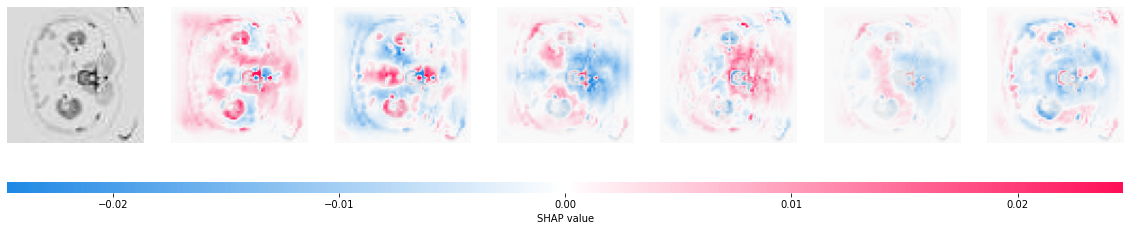

In [17]:
print(shap_plot(explain1, g_img))

[11.147785158164027,
 3.563165356462207,
 4.111415194634446,
 4.981590518405255,
 1.5849717871266193,
 2.1964975483719797]

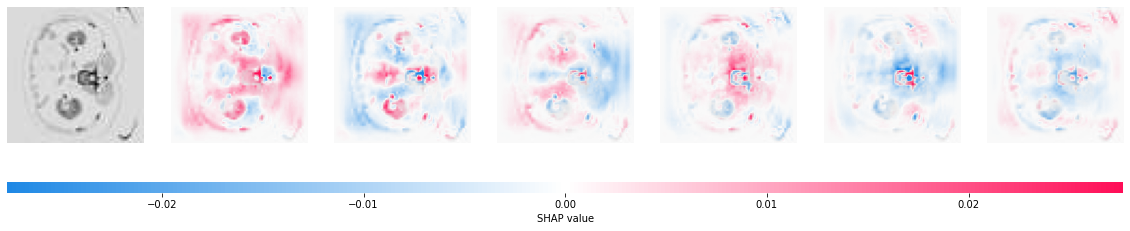

In [18]:
shap_plot(explain2, g_img)

[7.500937637200195,
 17.54706796029994,
 6.170572192697364,
 16.627376109058787,
 3.761986541759427,
 7.655146112681848]

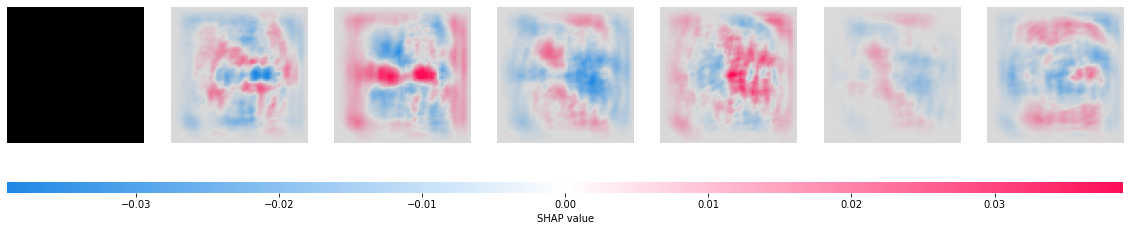

In [19]:
shap_plot(explain1, z_img)

[10.21232429816655,
 15.002016391553752,
 5.849852617341639,
 14.84727726030485,
 4.4626088737923055,
 5.384807845783598]

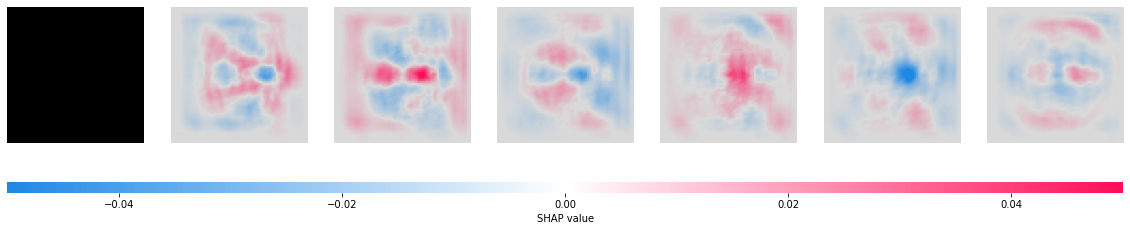

In [20]:
shap_plot(explain2, z_img)

<h1> End </h1>

##### 